### Build and Train GRU model with Implementation of Hyperparameter Tuning

In [2]:
#Import necessary modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold, train_test_split

In [3]:
%pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 863.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.4 MB/s eta 0:00:00


In [3]:
# Load the dataset
X = np.load('/content/drive/MyDrive/data/datasave/rolling_window_sequences.npy')  # Replace with actual file path
metadata_test = pd.read_csv("/content/drive/MyDrive/data/datasave/sequence_metadata_with_RUL.csv")  # Replace with actual file path
y = metadata_test["RUL"].values
print("Test feature shape:", X.shape)
print("Test target shape:", y.shape)

Test feature shape: (17631, 30, 66)
Test target shape: (17631,)


In [4]:
# Split the data into train and validation sets (assuming no separate train set given)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Define hyperparameters for tuning
params = {
    'units' : [32, 64],
    'batch_size': [16, 32],
    'epochs': 50,
    'learning_rate': [0.001, 0.005]
}

In [6]:
# Set up 5-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# Defin a function to build the GRU model
def build_gru_model(units, learning_rate, input_shape):
  model = Sequential()
  model.add(GRU(units=units, input_shape=input_shape, return_sequences=True))
  model.add(Dense(1))
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
  return model

In [8]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

In [9]:
import random
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

# Define parameter space
params = {
    "units": [32, 64, 128],
    "batch_size": [32, 64, 128],
    "learning_rate": [0.001, 0.0005],
    "epochs": 10   # keep epochs low during tuning
}

# Create random combinations (pick 5 random sets)
combinations = [(u, b, lr) for u in params["units"] for b in params["batch_size"] for lr in params["learning_rate"]]
random_combos = random.sample(combinations, 5)

# Setup KFold
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, verbose=0)
callbacks = [early_stop]

# Best tracking
best_val_loss = np.inf
best_model = None
best_params = None

# Random Search with K-Fold CV
for (units, batch_size, learning_rate) in random_combos:
    val_losses = []
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Build model
        model = build_gru_model(units, learning_rate, input_shape=(X.shape[1], X.shape[2]))

        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params["epochs"],
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        val_loss = min(history.history["val_loss"])
        val_losses.append(val_loss)

    # Average validation loss for this parameter set
    avg_val_loss = np.mean(val_losses)
    print(f"Params (units={units}, batch={batch_size}, lr={learning_rate}) → Avg Val Loss: {avg_val_loss:.4f}")

    # Update best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model
        best_params = (units, batch_size, learning_rate)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params (units=64, batch=32, lr=0.001) → Avg Val Loss: 3805.8186
Params (units=32, batch=64, lr=0.001) → Avg Val Loss: 5782.1273
Params (units=32, batch=32, lr=0.001) → Avg Val Loss: 4075.3419
Params (units=64, batch=128, lr=0.0005) → Avg Val Loss: 7396.8099
Params (units=32, batch=128, lr=0.0005) → Avg Val Loss: 9569.4648


In [10]:
print(f"Best validation loss: {best_val_loss}")
print(f"Best parameters: units={best_params[0]}, batch_size={best_params[1]}, learning_rate={best_params[2]}")

Best validation loss: 3805.818603515625
Best parameters: units=64, batch_size=32, learning_rate=0.001


In [11]:
# Save the best model
best_model.save('final_best_gru_model_cmapss.keras')

### Calculate the Metric Evaluation of GRU model

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [13]:
# Assuming test data (X_test, y_test) and trained model saved as "best_lstm_model.keras"
# Load test features and labels
X_test = np.load("/content/drive/MyDrive/data/datasave/rolling_window_sequences.npy")  # Replace with actual file path
metadata_test = pd.read_csv("/content/drive/MyDrive/data/datasave/sequence_metadata_with_RUL.csv")  # Replace with actual file path
y_test = metadata_test["RUL"].values

print("Test feature shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Test feature shape: (17631, 30, 66)
Test target shape: (17631,)


In [14]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/data/datasave/final_best_gru_model_cmapss.keras')

In [17]:
y_pred = model.predict(X_test)
# Keep only the last prediction for each sequence
y_pred = y_pred[:, -1, 0]
print("Predictions shape:", y_pred.shape)

551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Predictions shape: (17631,)


In [18]:
# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Root Mean Squared Error (RMSE): 61.6882
Mean Absolute Error (MAE): 50.2936


In [19]:
# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Root Mean Squared Error (RMSE): 61.6882
Mean Absolute Error (MAE): 50.2936


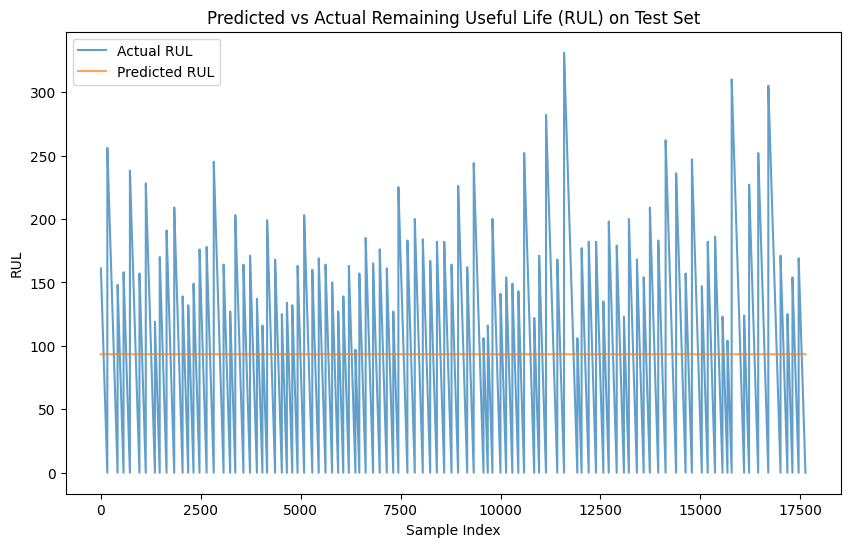

In [20]:
# Visualize Actual Vs Predict RUL
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual RUL', alpha=0.7)
plt.plot(y_pred, label='Predicted RUL', alpha=0.7)
plt.title('Predicted vs Actual Remaining Useful Life (RUL) on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()